In [1]:
# esta célula contém bibliotecas, métodos e funções (muitas), além do carregamento da base de treino, parâmetros
# para plots e 'seed' aplicada quando fosse necessário fornecer um 'random_state'

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from IPython.display import clear_output
import pickle

df = pd.read_pickle('treino.pkl.gz')

# ------- FUNÇÕES RELACIONADAS AO TRATAMENTO ESPECÍFICO DA VARIÁVEL 'score' (dentre os processos realizados 
#         pelas funções deste grupo, estão: alocação de valores abaixo de '20' sob a categoria '0', treino
#         e plot da árvore de decisão que virá a discretizar o restante dos dados (maiores que '20') e 
#         discretização das probabilidades retornadas pelas folhas da árvore         

def tratar_score1(dataframe, series_name, target, seed):
    plt.style.use('default')
    dataframe.loc[dataframe.index.isin(dataframe.loc[dataframe[series_name] < 20].index), series_name] = 0
    x = dataframe.loc[dataframe[series_name] != 0][[series_name]]
    y = dataframe.loc[dataframe[series_name] != 0][[target]]
    mdl = DecisionTreeClassifier(random_state = seed, max_depth = 2)
    mdl.fit(x, y)
    clear_output()
    fig = plt.figure(figsize = (12, 5))
    _ = tree.plot_tree(mdl)
    plt.show()

def tratar_score2(dataframe, series_name, target, t1, t2, t3): 
    z_series = dataframe.loc[dataframe[series_name] == 0][series_name]
    nonz_series = dataframe.loc[dataframe[series_name] != 0][series_name].apply(lambda x: 
                                                                score_new_disc(x, t1, t2, t3))

    disctzd_score = pd.concat([z_series, nonz_series])
    disctzd_score = disctzd_score.rename('new_score')
    dataframe = dataframe.join(disctzd_score).drop(columns = [series_name])
    return dataframe

def score_new_disc(x, t1, t2, t3):
    if x <= t1:
        return 1
    elif x > t1 and x <= t2:
        return 2
    elif x > t2 and x <= t3:
        return 3
    elif x > t3:
        return 4
    
# ------- FUNÇÃO RELACIONADA À DISCRETIZAÇÃO DE VARIÁVEIS ATRAVÉS DE ÁRVORES DE DECISÃO (mais especificamente, 
#         esta treina a árvore no split de treino, passado no parâmetro 'treino', em seguida, faz a 
#         discretização do split de teste, no parâmtero 'teste')
#         nota: 'score' não passa por esta, posto que foram criadas funções específicas para a mesma

def discretize(treino, teste, series_name, target, seed):
    
    mdl = DecisionTreeClassifier(max_depth = 2, random_state = seed)
    
    mdl.fit(treino[[series_name]], treino[target])
    teste[series_name + '_proba'] = mdl.predict_proba(teste[[series_name]])[:, 1] 
    
    
    thresh = teste[series_name + '_proba'].unique().tolist()
    thresh.sort()

    teste[series_name + '_proba'] = teste[series_name + '_proba'].apply(lambda x: 
                                                                discretize_proba(x, thresh)) 
    
    teste.drop(columns = [series_name], inplace = True)

# ------- FUNÇÃO CHAMADA NA DISCRETIZAÇÃO DE VARIÁVEIS (transforma as probabilidades de 'default' de cada folha
#         da árvore em valores discretos, por exemplo: caso a árvore retorne quatro folhas com probabilidades
#         de 'default': 0.15, 0.1, 0.12, 0.2; esta função nos auxilia a trasnformar a variável explicativa
#         em valores: 1, 2, 3, 4)
#         nota: ordenar e 'buscar' por correspondências nos dados são processos realizados em conjunto,
#         este é apenas um passo do processo

def discretize_proba(x, thresh):
    for n in range(len(thresh)):
        if x == thresh[n]:
            return n + 1

# ------- AS TRÊS PRÓXIMAS FUNÇÕES SÃO CHAMADAS EM CONJUNTO ('tree_box_plot()' chama as outras duas; o propósito
#         do processo desencadeado é fazer a análise de uma variável quantitativa, discretizando-a com uma
#         árvore de decisão e observando como a taxa de 'default' sobe, desce, ou não respeita a variação da
#         variável explicativa)

def proba_box(dataframe, series_name, target, max_depth, random_state):
    
    disc = DecisionTreeClassifier(max_depth = max_depth, random_state = random_state)
    disc.fit(dataframe[[series_name]], dataframe[[target]])
    dataframe[series_name + '_proba'] = disc.predict_proba(dataframe[[series_name]])[:, 1] 
    
    thresh = dataframe[series_name + '_proba'].unique().tolist()
    thresh.sort()

    dataframe[series_name + '_proba'] = dataframe[series_name + '_proba'].apply(lambda x: 
                                                                discretize_proba(x, thresh)) 
    
    thresh = [round(i, 5) for i in thresh]
    print(thresh)
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (11, 5)
    sns.boxplot(dataframe[series_name + '_proba'], dataframe[series_name], showfliers = False)
    plt.show()
    
def tree_thresholds(dataframe, series_name, target, max_depth, random_state):
    mdl = DecisionTreeClassifier(random_state = random_state, max_depth = max_depth)
    mdl.fit(dataframe[[series_name]], dataframe[[target]])
    plt.style.use('default')
    fig = plt.figure(figsize = (12, 5))
    _ = tree.plot_tree(mdl)
    plt.show()

def tree_box_plot(dataframe, series_name, target, iterations, random_state, show_tree = True):
    if show_tree == True:
        for i in iterations:
            tree_thresholds(dataframe, series_name, target, i, random_state)
            proba_box(dataframe, series_name, target, i, random_state)
    
    else:
        for i in iterations:
            tree_thresholds(dataframe, series_name, target, i, random_state)
            clear_output()
            proba_box(dataframe, series_name, target, i, random_state)
            
# ------- FUNÇÃO PARA ANÁLISE DE VARIÁVEIS CATEGÓRICAS (teste qui-quadrado e Crámer's V)
def quali_var_indep_hyp_test(dataframe, series_name, target, alpha):
    
    stat, pval, dof, exp = chi2_contingency(pd.crosstab(dataframe[series_name], dataframe[target]))
    crit = chi2.ppf(q = (1 - alpha), df = dof)
    
    if stat >= crit:
        cramer = np.sqrt( ( stat ) / sum(sum(exp)) * (min(exp.shape) - 1) )
    else:
        cramer = None
    
    return stat, crit, cramer

# ------- FUNÇÕES REFERENTES AO 'STEPWISE REGRESSION'(primeiramente, é feito o split para treino e teste, em 
#         seguida, as variáveis são normalizadas, então prosseguimos para o treino e teste de modelos de 
#         regressão logística para diferentes conjuntos de features; o primeiro step roda com todas as features,
#         armazenamos em um dicionário, este conjunto e seu score, então, buscamos pela variável de menor 
#         coeficiente, eliminamos esta e repetimos o processo até que haja apenas uma variável explicativa,
#         ao chegarmos a este ponto, plotamos as informações do dicionário, e podemos observar como a métrica
#         se comporta conforme eliminamos features)
def pre_proc_and_split(dataframe, target):
    
    aux = dataframe.copy()
    cols = aux.columns.tolist()
    cols.remove(target)
    
    x = aux[cols]
    y = aux[target]
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)
                                        
    for i in cols:
        nr = Normalizer()
        X_train[i] = nr.fit_transform(X_train[[i]])
        X_test[i] = nr.transform(X_test[[i]])
        
    return X_train, X_test, y_train, y_test

def step(xtrain, xtest, ytrain, ytest):
    lr = LogisticRegression()
    lr.fit(xtrain, ytrain)
    pred = lr.predict_proba(xtest)
    
    pr = [i[1] for i in pred]

    score = roc_auc_score(y_true = ytest, y_score = pr) 

    cfs = lr.coef_.tolist()[0]
    cfs = [abs(i) for i in cfs]
    lista = [i for i in zip(cfs, xtest.columns)]
    lista.sort()
    data_cfs = [i[0] for i in lista]
    data_feats = [i[1] for i in lista]

    dropd = lista[0][1]
    lista = lista[1:]
    remaining_feats = [i[1] for i in lista]
    
    return remaining_feats, score, dropd

def my_stepwise(dataframe, target):
    itr = len(dataframe.drop(columns = [target]).columns.tolist()) 
    dici = {}

    for n in range(itr):
    
        xtrain, xtest, ytrain, ytest = pre_proc_and_split(dataframe, target)
        clear_output()
        remaining, score, dropd = step(xtrain, xtest, ytrain, ytest)
        dici[n] = [score, dataframe.columns.tolist()]
        dataframe = dataframe.drop(columns = [dropd])
        
    return dici

def plot_stepwise(dataframe, target):
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = (10, 5)
    d = my_stepwise(dataframe, target)

    plot_vals = []
    for i in d.keys():
        plot_vals.append(d[i][0])
    
    plt.plot(plot_vals)
    plt.show()

    print('FEATURES INCLUÍDAS EM CADA STEP')
    for i in d.keys():
        fs = d[i][1].remove('default')
        print(i , ':', d[i][1])
    print('')
    print('SCORE DE CADA STEP')
    for i in d.keys():
        print(i , ':', round(d[i][0], 5))

# FUNÇÕES REFERENTES À TRANSFORMAÇÃO DE VARIÁVEIS EXPLICATIVAS
# transofrmando 'nascimento' em 'idade'
def year_to_age(x):

    if x == '00':
        return 20   
    else:
        return (100 - int(x)) + 20

# transformando 'anos e meses' em 'meses' ('2yrs 2mon' em '26')
def time_unit_unification(x):
    
    sub1 = x.split(' ')[0]
    sub2 = x.split(' ')[1]
    return (int(sub1.strip('yrs')) * 12) + int(sub2.strip('mon'))

# FUNÇÕES REFERENTES AO PRÉ PROCESSAMENTO DE DADOS PARA TESTE DE MODELOS
# pipeline para tratar e testar dados
# o processo abaixo trata de fazer três splits para validação cruzada,
# discretizar cada split corretamente, sem data leak ao empregar árvores na discretização

def post_stepwise_split(data):
    
    df = pd.read_pickle('treino.pkl.gz')
    df = df.copy()[data]

    df['nascimento'] = df['nascimento'].str[6:].apply(lambda x: year_to_age(x))
    df = df.rename(columns = {'nascimento': 'idade'})
    df['tem_med_emp'] = df['tem_med_emp'].apply(lambda x: time_unit_unification(x))
    df['tem_pri_emp'] = df['tem_pri_emp'].apply(lambda x: time_unit_unification(x))

    kf = KFold(n_splits = 3, random_state = seed, shuffle = True)
    d = {}
    n = 0
    for train_index, test_index in kf.split(df):
        d[n] = [[train_index.tolist()], [test_index.tolist()]]
        n += 1

    treino_0 = df.iloc[d[0][0][0]]
    teste_0 = df.iloc[d[0][1][0]]

    treino_1 = df.iloc[d[1][0][0]]
    teste_1 = df.iloc[d[1][1][0]]

    treino_2 = df.iloc[d[2][0][0]]
    teste_2 = df.iloc[d[2][1][0]]
    
    return treino_0, teste_0, treino_1, teste_1, treino_2, teste_2

# discretização de treino e teste, uma vez selecionadas as features (pós-stepwise)
def post_stepwise_split_discretization(teste_0,teste_1,teste_2,treino_0,treino_1,treino_2, data,
                                      limiares0, limiares1, limiares2):
    
    teste_0 = tratar_score2(teste_0, 'score', 'default', limiares0[0], limiares0[1], limiares0[2])
    treino_0 = tratar_score2(treino_0, 'score', 'default', limiares0[0], limiares0[1], limiares0[2])
    
    teste_1 = tratar_score2(teste_1, 'score', 'default', limiares1[0], limiares1[1], limiares1[2])
    treino_1 = tratar_score2(treino_1, 'score', 'default', limiares1[0], limiares1[1], limiares1[2])
    
    teste_2 = tratar_score2(teste_2, 'score', 'default', limiares2[0], limiares2[1], limiares2[2])
    treino_2 = tratar_score2(treino_2, 'score', 'default', limiares2[0], limiares2[1], limiares2[2])

    # é importante manter a ordem dos loops abaixo, posto que queremos treinar as árovres que discretizarão
    # os dados de teste em dados não discretizados

    # aqui são discretizados os splits de teste, com árvores treinadas em split de treino
    for col in data:
        discretize(treino_0, teste_0, col, 'default', seed)
        discretize(treino_1, teste_1, col, 'default', seed)
        discretize(treino_2, teste_2, col, 'default', seed)
    
    # aqui são discretizados os splits de treino    
    for col in data:
        tree_box_plot(treino_0, col, 'default', [2], seed, False)
        treino_0.drop(columns = [col], inplace = True)
        tree_box_plot(treino_1, col, 'default', [2], seed, False)
        treino_1.drop(columns = [col], inplace = True)
        tree_box_plot(treino_2, col, 'default', [2], seed, False)
        treino_2.drop(columns = [col], inplace = True)
        clear_output()
        
    return teste_0,teste_1,teste_2,treino_0,treino_1,treino_2

# teste em regressão logística e lgbm, métrica gini
def lr_lgbm_score(treino_0, teste_0 ,treino_1, teste_1 ,treino_2, teste_2, data):
    lgbm_scores = []
    lr_scores = []
    for i in [[treino_0, teste_0], [treino_1, teste_1], [treino_2, teste_2]]:    
        lr = LogisticRegression()
        lr.fit(i[0][data], i[0]['default'].values.ravel())

        te = 2 * roc_auc_score(i[1]['default'], [n[1] for n in lr.predict_proba(i[1][data])]) - 1
        tr = 2 * roc_auc_score(i[0]['default'], [n[1] for n in lr.predict_proba(i[0][data])]) - 1
        lr_scores.append([te, tr])
    
        lgbm = LGBMClassifier(n_estimators = 500, learning_rate = 0.1, random_state = seed)
        lgbm.fit(i[0][data], i[0]['default'].values.ravel())

        te = 2 * roc_auc_score(i[1]['default'], [n[1] for n in lgbm.predict_proba(i[1][data])]) - 1
        tr = 2 * roc_auc_score(i[0]['default'], [n[1] for n in lgbm.predict_proba(i[0][data])]) - 1
        lgbm_scores.append([te, tr])
        
    return lgbm_scores, lr_scores

def score_data(score_list):
    test_scores = 0
    train_scores = 0
    overfit = 0

    for i in score_list:
        test_scores += i[0]
        train_scores += i[1]
        overfit += (i[1] - i[0])
    
    return {'test_avg':(test_scores/3), 'train_avg':(train_scores/3), 'overfit_avg':(overfit/3)}

# parâmteros para plots e seed utilizada neste projeto
plt.rcParams['figure.figsize'] = (16, 8)
seed = 123

In [2]:
# AQUI SE INICIA A ANÁLISE DA BASE

# seleção preliminar de features:
# o critério desta foi: lógica / explicabilidade, as features eliminadas são consideradas como não relacionadas
# à probabilidade de 'deafult', as variáveis abaixo foram consideradas como relevantes à probabilidade de 
# inadimplência e serão analisadas mais a fundo, estão divididas em itens de 'a - g', para facilitar a 
# organizção do notebook

#  a. 'valor_emprestimo', 'custo_ativo', 'emprestimo_custo' 
#  b. 'nascimento' 
#  c. 'emprego'  
#  d. 'score', 'score_desc'  
#  e. 'qtd_sol_emp' 
#  f. 'tem_med_emp', 'tem_pri_emp' 
#  g. 'pri_emp_san','pri_emp_tom', 'pri_qtd_tot_emp', 'pri_qtd_tot_emp_atv', 'pri_qtd_tot_def', 'pri_emp_abt'

# iniciamos a análise discretizando variávies quantitativas, caso ordenem o 
# 'default', mantemos estas na análise, caso contrário, já podemos desconsiderá-las, já as variáveis 
# qualitativas são avaliadas com teste qui-quadrado e cramer v
# posteriormente, avaliamos a importância das features restantes, por meio de um
# stepwise

# ------- sobre a discretização de variáveis quantitativas:
# este processo foi realizado através de árvores de decisão, uso o método 'predict_proba'
# para criar uma nova series nos dados; se determinamos que a profundidade máxima da árvore será de 
# '2', temos '4' folhas, ou seja, '4' bins, ou '4' valores únicos nesta nova series, criada à partir
# do retorno do método 'predict_proba', esta series é discretizada, o valor mais baixo de probabilidade
# de 'default' entre as folhas é transformado em '1', o segundo mais baixo em '2', assim por diante; 
# assim, se plotarmos um boxplot desta variável, contendo as probabilidades discretizadas,
# com a variável original, podemos observar quais são os ranges de valores para cada probabilidade;
# este processo de discretização é aplicado a todas as variáveis quantitativas)
# nota: para o teste do modelo, e predição da base que foi entregue (que não contém a variável alvo), a 
# discretização é feita com atenção à possibilidade de 'dataleak', dados splits de treino e teste, a árvore
# é treinada no split de treino, a árvore é plotada, toma-se nota de quais são os limiares da árvore, em
# seguida, discretizamos os valores do split de teste com estes (a discretização foi feita desta forma porque
# não consegui adaptar as funções que discretizam dados para a análise dos dados de sem treino e teste, ao
# novo contexto, onde este split se faz necessário)

# nota:
# grande parte da análise consiste em discretizar variáveis contínuas e verificar se a taxa de 'default' entre
# bins sobe ou desce respeitando os mesmos, foram testados 16, 8 e 4 bins, com raras exceções, 4 bins foi
# o único número que 'ordenava o default', pensando na 'limpeza' do notebook, os plots incluem apenas
# a discretização em 4 bins

In [3]:
# checagem dos dados que serão analisados

df[['valor_emprestimo', 'custo_ativo', 'emprestimo_custo', 'nascimento', 'emprego', 'score', 'score_desc',
'qtd_sol_emp', 'tem_med_emp', 'tem_pri_emp', 'pri_emp_san', 'pri_emp_tom', 'pri_qtd_tot_emp',
'pri_qtd_tot_emp_atv', 'pri_qtd_tot_def', 'pri_emp_abt', 'default']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186523 entries, 155653 to 57003
Data columns (total 17 columns):
valor_emprestimo       186523 non-null int64
custo_ativo            186523 non-null int64
emprestimo_custo       186523 non-null float64
nascimento             186523 non-null object
emprego                180376 non-null object
score                  186523 non-null int64
score_desc             186523 non-null object
qtd_sol_emp            186523 non-null int64
tem_med_emp            186523 non-null object
tem_pri_emp            186523 non-null object
pri_emp_san            186523 non-null int64
pri_emp_tom            186523 non-null int64
pri_qtd_tot_emp        186523 non-null int64
pri_qtd_tot_emp_atv    186523 non-null int64
pri_qtd_tot_def        186523 non-null int64
pri_emp_abt            186523 non-null int64
default                186523 non-null int64
dtypes: float64(1), int64(11), object(5)
memory usage: 25.6+ MB


In [4]:
# balanceamento (ou não) da base

df['default'].value_counts(1)

0    0.783608
1    0.216392
Name: default, dtype: float64

In [5]:
# a análise dos dados é feita na base de treino inteira, posteriormente, para testagem de modelos, esta
# é dividida em treino e teste, o pré processamento aplicado durante as análises é reproduzido nos dados
# de treino e teste (transformações que envolvem unidade de medida são feitas da mesma forma nos splits,
# já na discretização com árvore de decisão, é criada uma árvore para cada conjunto de treino e teste, 
# as árvores são ajustadas aos dados de treino de cada conjunto, em seguida, estas árvores 'transformam'
# ambos os dados de treino e teste de cada conjunto)

# a.

In [6]:
# valor_emprestimo -> Valor total emprestado pela financeira
# custo_ativo -> Custo do ativo (veículo)
# emprestimo_custo -> Razão entre valor emprestado e valor do ativo (veículo)

# já 'por definição', conclui-se que 'emprestimo_custo' estará altamente correlacionada a uma combinação entre
# 'valor_emprestimo' e 'custo_ativo', estas que, por sua vez, também possuem correlação entre si, como demonstro
# abaixo

In [7]:
pearsonr(df['custo_ativo'], df['valor_emprestimo'])

(0.756227463624271, 0.0)

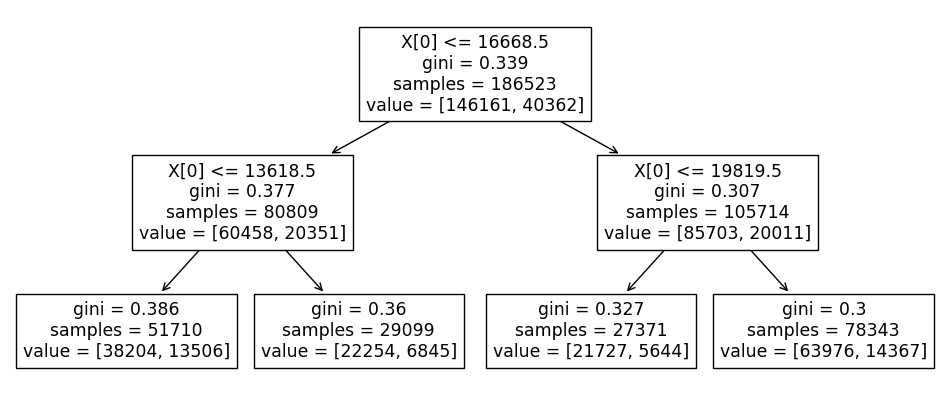

[0.18339, 0.2062, 0.23523, 0.26119]


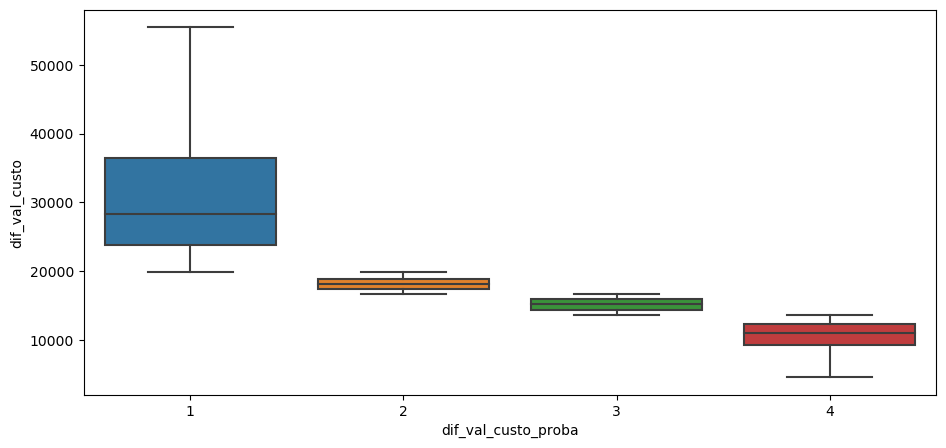

In [8]:
# combinando 'custo_ativo' e 'valor_emprestimo' (independente da correlação, é uma operação intuitiva)
df['dif_val_custo'] = df['custo_ativo'] - df['valor_emprestimo'] 
# discretizando a variável resultante
tree_box_plot(df, 'dif_val_custo', 'default', [2], seed, True)

# nos box plots, as abscissas contém inteiros representando as probabilidades de 'default' para dados de 
# cada bin, logo acima das imagens, é impressa uma lista com número de elementos idêntico ao número de bins;
# o primeiro elemento da lista corresponde ao bin de número 1, o segundo elemento da lista corresponde ao bin
# de número 2, assim por diante, os boxes em si compreendem os valores da variável que foram alocados sob
# aquele bin (os outliers não são exibidos), a árovre impressa contém as regras para divisão dos bins

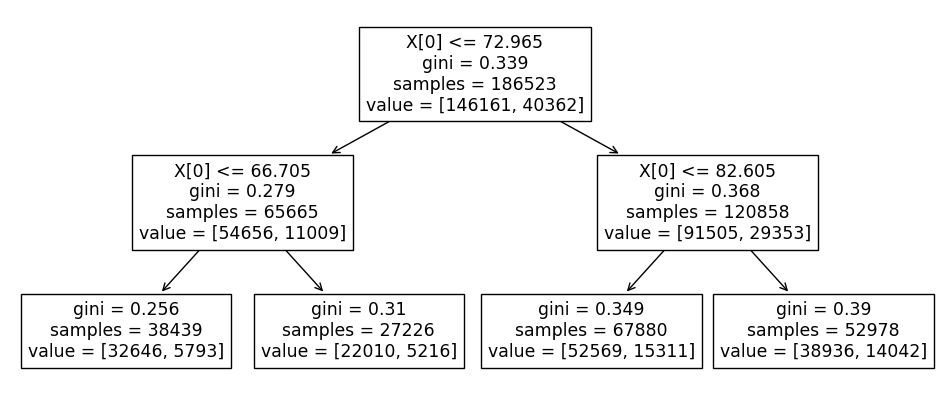

[0.15071, 0.19158, 0.22556, 0.26505]


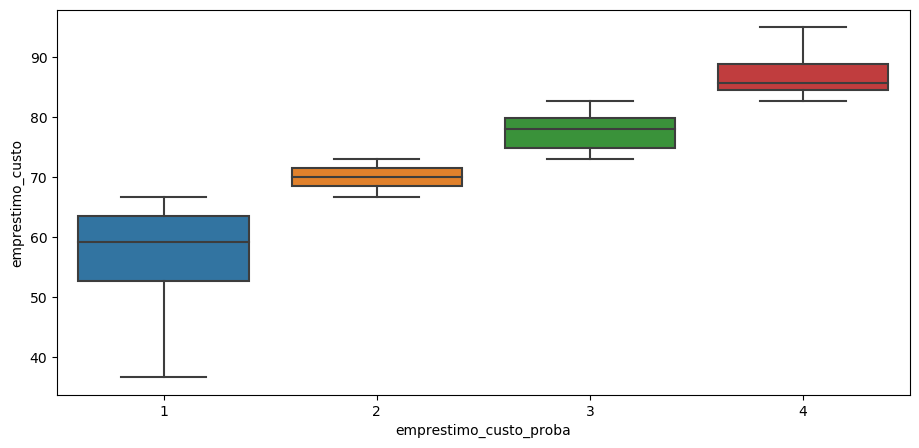

In [9]:
tree_box_plot(df, 'emprestimo_custo', 'default', [2], seed, True)

In [10]:
# conclusão de a.: combinamos 'custo_ativo' e 'valor_emprestimo' em uma única variável, uma vez que possuem
# correlação significativa, em seguida, ao discretizar e plotar os bins, percebemos que a variável discretizada
# ordena o 'default', portanto, esta é válida; prosseguimos com 'emprestimo_custo', ao plotar os bins, 
# fica evidente que esta também ordena o 'default', apesar de possuir correlação com 'dif_custo_val', não
# sei como poderia combiná-las, sendo assim, 'dif_custo_val' e 'emprestimo_custo' permanencem na análise

# b.

In [11]:
# nascimento -> Data de nascimento

# partindo do pressuposto de que a idade do indivíduo possa torná-lo mais suscetível a inadimplência, 
# transformamos a coluna 'nascimento' em 'idade'

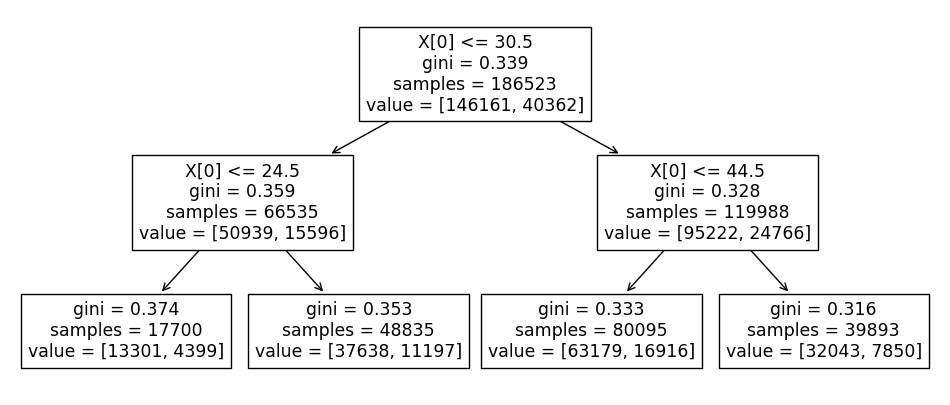

[0.19678, 0.2112, 0.22928, 0.24853]


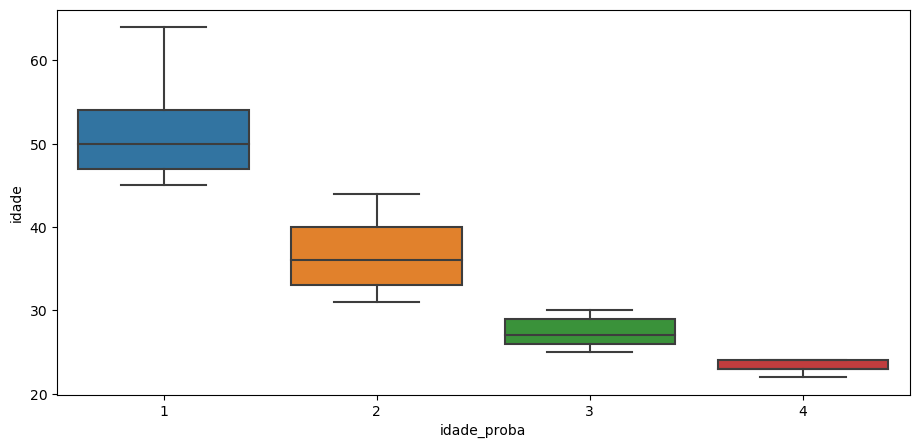

In [12]:
df['nascimento'] = df['nascimento'].str[6:].apply(lambda x: year_to_age(x))
df = df.rename(columns = {'nascimento': 'idade'})
tree_box_plot(df, 'idade', 'default', [2], seed, True)

In [13]:
# conclusão de b.: por mais que possa gerar controvérsias, a variável 'idade' ordena o 'default', logo,
# mantemos esta no modelo

# c.

In [14]:
# emprego -> Tipo de emprego

# considerando que possa haver uma influência do tipo de emprego na renda do indivíduo, esta que por sua vez, 
# estaria relacionada à habilidade do mesmo de quitar suas dívidas, prosseguimos com a análise de 'emprego'

In [15]:
# imputando valores 'nan'
imp = SimpleImputer(strategy = 'constant', fill_value = 'Unknown')
df['emprego'] = imp.fit_transform(df[['emprego']])
df['emprego'] = df['emprego'].str.replace(' ', '_')

stat, crit, cramer = quali_var_indep_hyp_test(df, 'emprego', 'default', 0.05)

print(f'estatística qui-quadrada: {round(stat, 2)}')
print(f'valor_crítico: {round(crit, 2)}')
print(f"Cramér's V: {round(cramer, 3)}")

estatística qui-quadrada: 145.54
valor_crítico: 5.99
Cramér's V: 0.028


In [16]:
# conclusão de c.: Com uma estatística qui-quadrada de 145.54, e um valor crítico de 5.99, falhamos em rejeitar 
# a hipótese nula de independência, todavia, para quantificarmos a associação entre 'emprego' e 'default', 
# consultamos Cramér's V, que acusa associação insignificante

# d.

In [17]:
# score -> Score do Bureau
# score_desc -> Descrição do Score

# seria seguro supor a redundância destas variáveis, entretanto, segue a
# análise destas, a fim de garantir que não perderemos informação, ao eliminar uma delas

df['score_desc'].value_counts(1)

No Bureau History Available                                0.502340
C-Very Low Risk                                            0.068828
A-Very Low Risk                                            0.060464
D-Very Low Risk                                            0.048750
B-Very Low Risk                                            0.039309
M-Very High Risk                                           0.037872
F-Low Risk                                                 0.036709
K-High Risk                                                0.035202
H-Medium Risk                                              0.029214
E-Low Risk                                                 0.024812
I-Medium Risk                                              0.023338
G-Low Risk                                                 0.017161
J-High Risk                                                0.016111
Not Scored: Sufficient History Not Available               0.016084
Not Scored: Not Enough Info available on the cus

In [18]:
# em um primeiro momento, de forma grosseira, considero a possibilidade de dividir os possíveis valores de 
# 'score_desc' entre possuindo a palavra 'Risk' ou se iniciar com 'No'

print(df.loc[df['score_desc'].str.contains('No'), 'score_desc'].unique().tolist())
print('')
print(df.loc[(df['score_desc'].str.contains('Risk')) | 
                    (df['score_desc'].str.contains('Risk')), 'score_desc'].unique().tolist())

['No Bureau History Available', 'Not Scored: Only a Guarantor', 'Not Scored: No Updates available in last 36 months', 'Not Scored: No Activity seen on the customer (Inactive)', 'Not Scored: Sufficient History Not Available', 'Not Scored: Not Enough Info available on the customer', 'Not Scored: More than 50 active Accounts found']

['F-Low Risk', 'A-Very Low Risk', 'C-Very Low Risk', 'H-Medium Risk', 'M-Very High Risk', 'K-High Risk', 'B-Very Low Risk', 'I-Medium Risk', 'D-Very Low Risk', 'E-Low Risk', 'J-High Risk', 'G-Low Risk', 'L-Very High Risk']


In [19]:
# aprofundando análise dos valores de 'score_desc' que possuem 'Risk' ou 'risk'

print(df.loc[df['score_desc'].str.contains('Very Low'), 'score_desc'].unique())
print(df.loc[(df['score_desc'].str.contains('Low')) &
     (df['score_desc'].str.contains('Very') == False), 'score_desc'].unique())
print(df.loc[df['score_desc'].str.contains('Medium'), 'score_desc'].unique())
print(df.loc[(df['score_desc'].str.contains('High')) &
             (df['score_desc'].str.contains('Very') == False), 'score_desc'].unique())
print(df.loc[df['score_desc'].str.contains('Very High'), 'score_desc'].unique())

['A-Very Low Risk' 'C-Very Low Risk' 'B-Very Low Risk' 'D-Very Low Risk']
['F-Low Risk' 'E-Low Risk' 'G-Low Risk']
['H-Medium Risk' 'I-Medium Risk']
['K-High Risk' 'J-High Risk']
['M-Very High Risk' 'L-Very High Risk']


In [20]:
# o que querem dizer as letras?
# são subgrupos de cada tipo de risco, o risco aumenta conforme se percorre o alfabeto

# como se comporta o 'score', para cada 'score_desc' ?

df_risk_letter = df.copy()
df_risk_letter = df_risk_letter.loc[(df_risk_letter['score_desc'].str.contains('Risk')) |
                                    (df_risk_letter['score_desc'].str.contains('risk'))]
df_risk_letter['risk_letter'] = df_risk_letter['score_desc'].str[0]
df_risk_letter[['risk_letter', 'score']].groupby('risk_letter').mean()

,score
risk_letter,
A,827.646657
B,774.158211
C,741.895311
D,715.966128
E,691.516206
F,666.132175
G,640.968760
H,617.100385
I,586.856651


In [21]:
df_risk_word = df.copy()
df_risk_word = df_risk_word.loc[(df_risk_word['score_desc'].str.contains('Risk')) |
                 (df_risk_word['score_desc'].str.contains('risk'))]
df_risk_word['risk_word'] = df_risk_word['score_desc'].str[2:]
df_risk_word[['risk_word', 'score']].groupby('risk_word').mean().sort_values('score')

,score
risk_word,
Very High Risk,303.005018
High Risk,474.778707
Medium Risk,603.669353
Low Risk,668.648474
Very Low Risk,765.769443


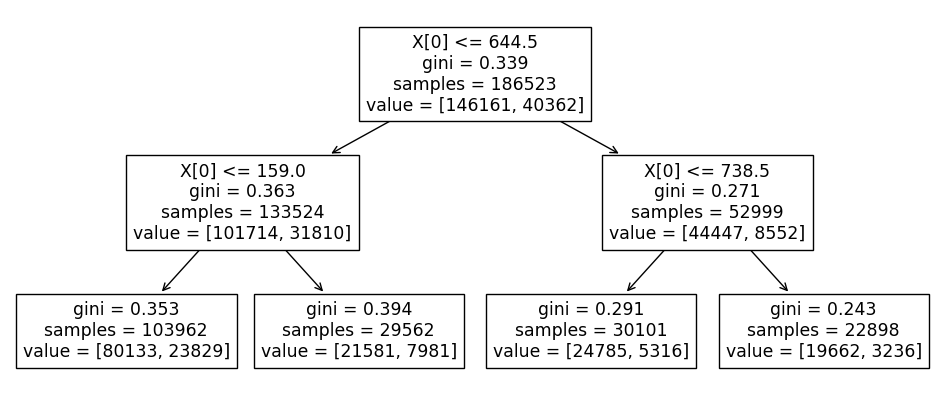

[0.14132, 0.17661, 0.22921, 0.26997]


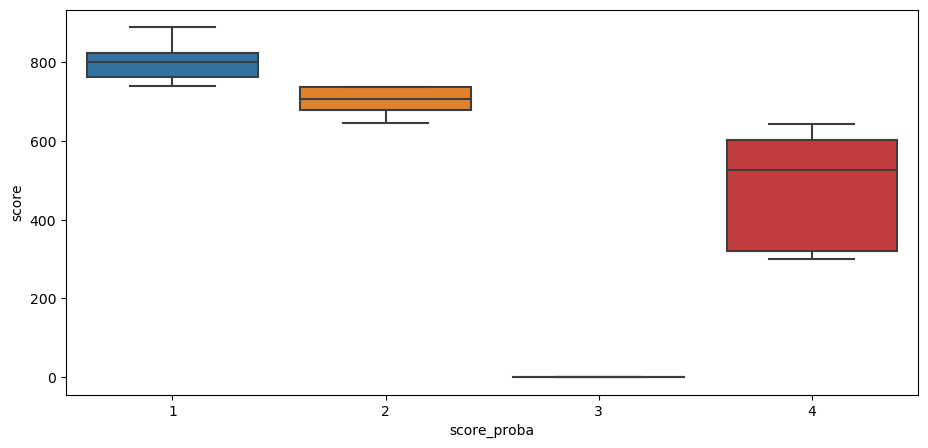

In [22]:
# com estas informações, concluo que não há necessidade de manter ambas variáveis('score' e 'score_desc')
# opto por manter 'score'

# prosseguindo com a análise de 'score'
tree_box_plot(df, 'score', 'default', [2], seed, True)

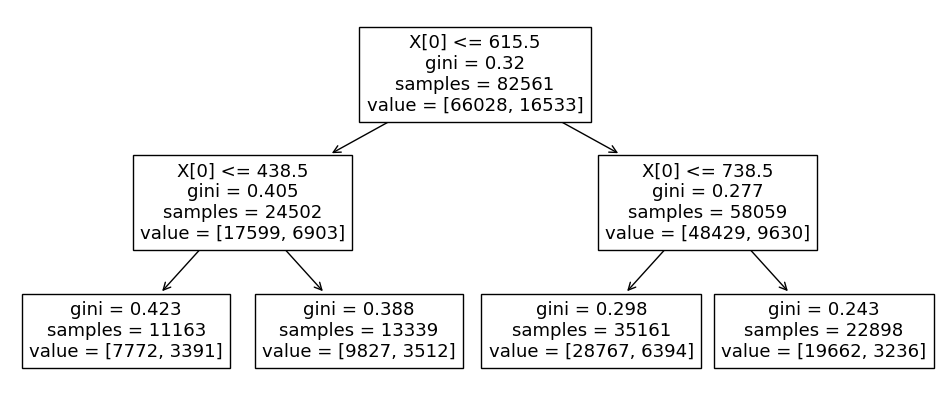

[0.14132, 0.18185, 0.26329, 0.30377]


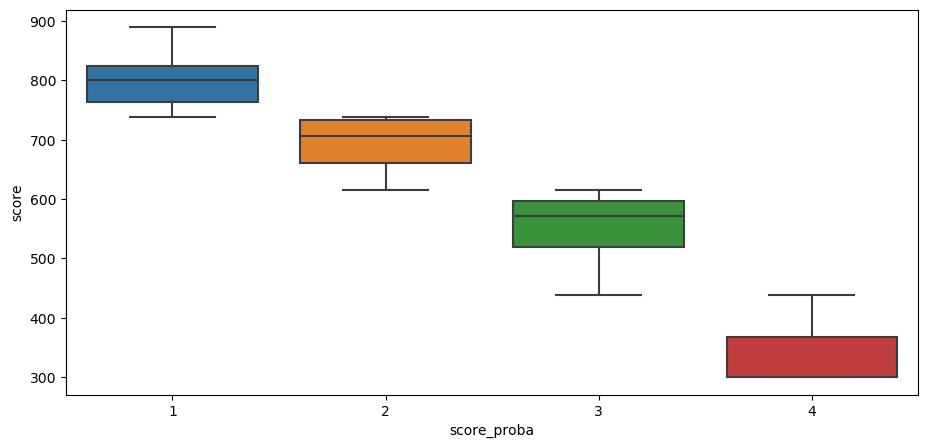

In [23]:
# o grande número de scores iguais a 0 torna a variável 'score' menos confiável, 
# para contornar este problema, podemos alocar este grupo de dados sob a categoria 0, antes de passar os
# dados no modelo

aux = df.copy()
aux = aux.loc[df['score'] > 20]
tree_box_plot(aux, 'score', 'default', [2], seed, True)

In [24]:
# conclusão de d.: podemos manter apenas 'score', esta precisa ser tratada separadamente,
# alocando certos valores sob a categoria '0', e prosseguindo com a discretização nao restante dos dados

# e.

In [25]:
# qtd_sol_emp -> Solicitações de empréstimos feitas pelo cliente

# são dados referentes ao histórico do cliente consideramos que possa haver alguma influência da quantidade de
# solicitações de empréstimos que o cliente fez com sua capacidade de quitar os empréstimos

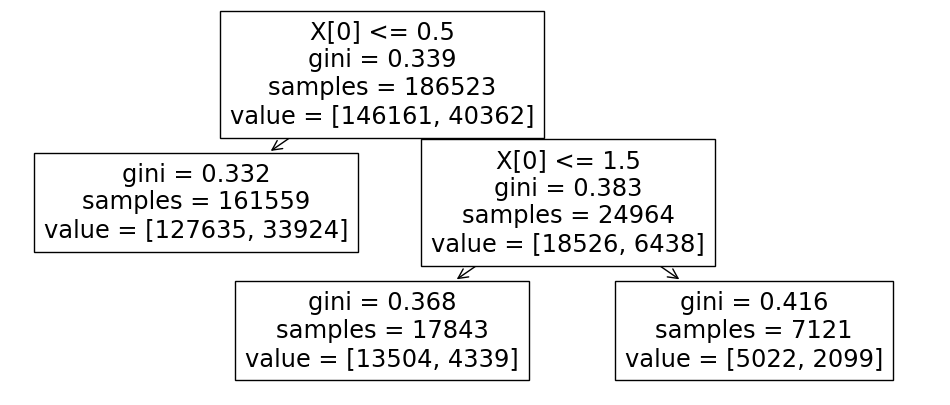

[0.20998, 0.24318, 0.29476]


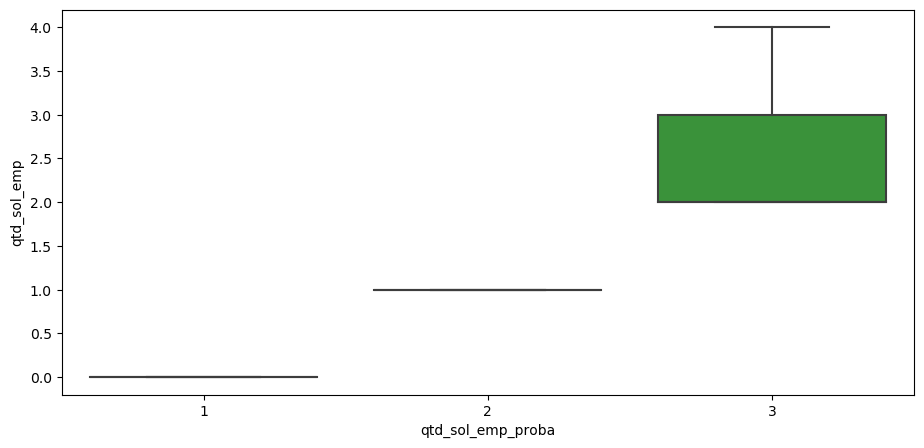

In [26]:
tree_box_plot(df, 'qtd_sol_emp', 'default', [2], seed, True)

In [27]:
# conclusão de e.: a variável se mantém na análise (ordena o 'default')

# f.

In [28]:
# 'tem_med_emp' -> Tempo médio de empréstimo
# 'tem_pri_emp' -> Tempo desde o primeiro empréstimo

# dados referentes ao histórico do cliente
# é importante levar o tempo médio em consideração pois traz a média de anos/meses que durou o empréstimo feito
# pelo cliente, isto é, qual foi o tempo médio que o cliente levou para quitar seus empréstimos.

# quanto ao tempo desde o primeiro empréstimo, é uma informação sobreo o histórico do cliente, será verificado
# abaixo se realmente possui ligação com a variável resposta, para definir se utilizaremos ou não no modelo.

In [29]:
# transformando as variáveis 'tem_med_emp', 'tem_pri_emp', inicialmente, no formato (n yrs n mons), transformo
# estas em um inteiro representando o número de meses (ex: 1yrs 1mon passa a ser 13)

df['tem_med_emp'] = df['tem_med_emp'].apply(lambda x: time_unit_unification(x))
df['tem_pri_emp'] = df['tem_pri_emp'].apply(lambda x: time_unit_unification(x))

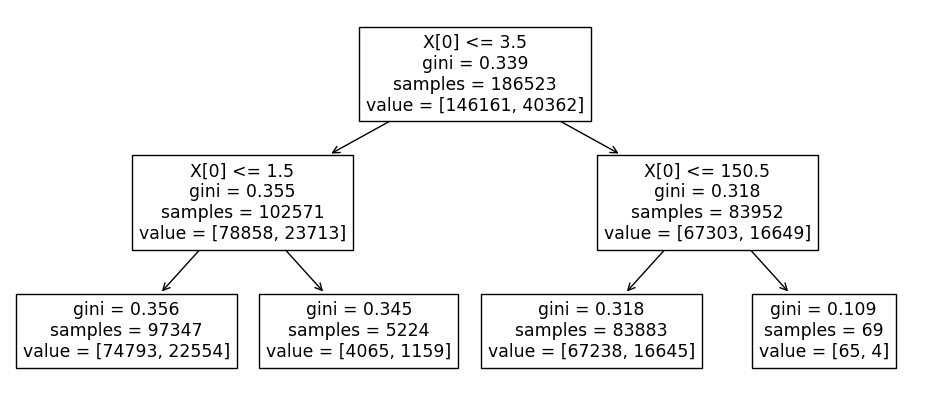

[0.05797, 0.19843, 0.22186, 0.23169]


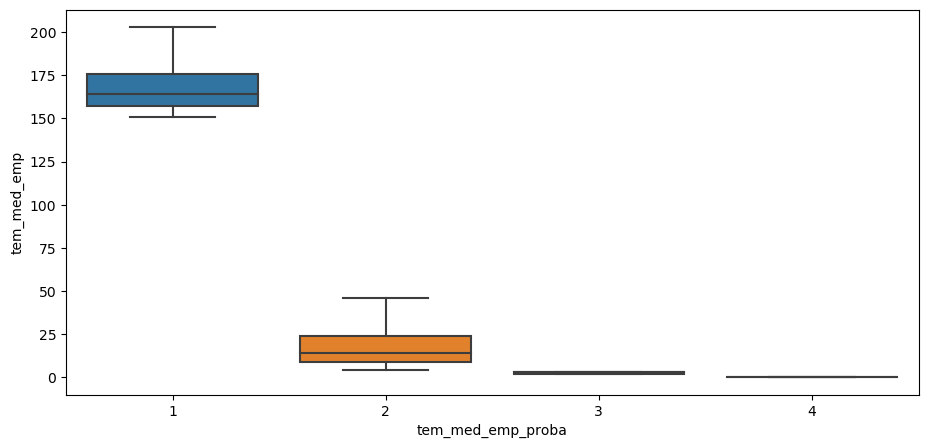

In [30]:
tree_box_plot(df, 'tem_med_emp', 'default', [2], seed, True)

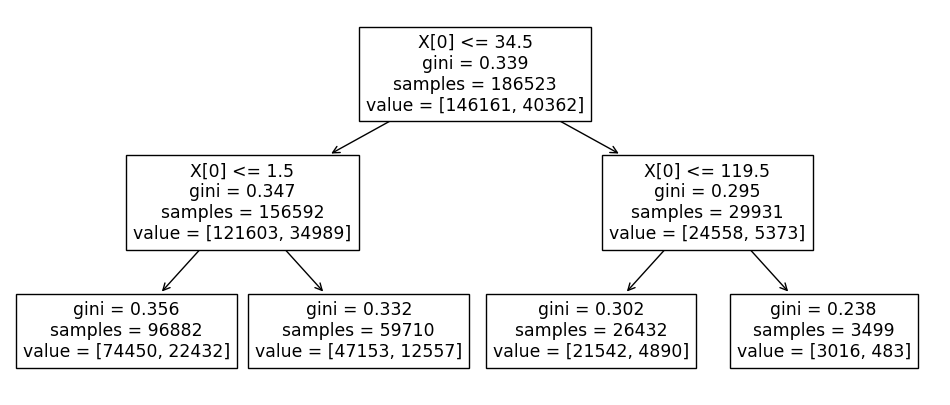

[0.13804, 0.185, 0.2103, 0.23154]


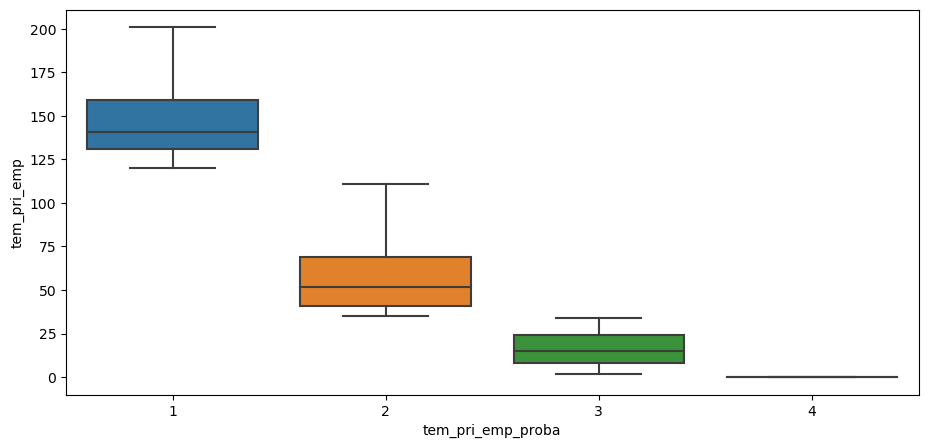

In [31]:
tree_box_plot(df, 'tem_pri_emp', 'default', [2], seed, True)

In [32]:
# conclusão de f.: ambas ordenam o default, também possuem correlação entre si, mas como não sei como 
# combiná-las, mantenho-as no modelo

# g.

In [33]:
df[['pri_qtd_tot_emp', 'pri_qtd_tot_emp_atv', 'pri_qtd_tot_def', 'pri_emp_abt', 
           'pri_emp_san','pri_emp_tom']].corr()

# dados referentes à conta primária do cliente

# percebe-se correlação entre 'pri_qtd_tot_emp' e 'pri_qtd_tot_emp_atv' e 
# 'pri_emp_san' e 'pri_emp_tom' 

# cominarei cada par em uma única variável, assim, além destas duas variáveis resultantes, nos restam:
# pri_qtd_tot_def
# pri_emp_abt

# em g., serão discretizadas quatro variáveis 'finais'

,pri_qtd_tot_emp,pri_qtd_tot_emp_atv,pri_qtd_tot_def,pri_emp_abt,pri_emp_san,pri_emp_tom
pri_qtd_tot_emp,1.000000,0.747670,0.349785,0.294923,0.144879,0.144305
pri_qtd_tot_emp_atv,0.747670,1.000000,0.380439,0.409261,0.202903,0.202099
pri_qtd_tot_def,0.349785,0.380439,1.000000,0.228309,0.109751,0.110922
pri_emp_abt,0.294923,0.409261,0.228309,1.000000,0.432959,0.438819
pri_emp_san,0.144879,0.202903,0.109751,0.432959,1.000000,0.998797
pri_emp_tom,0.144305,0.202099,0.110922,0.438819,0.998797,1.000000


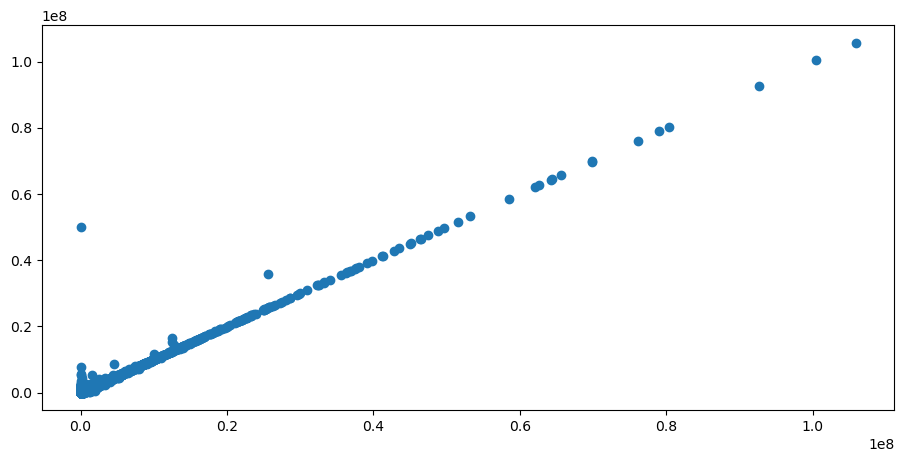

In [34]:
# montante de empréstimo sancionado e montante de empréstimo tomado (correlação muito alta 0.99)
aux = df.copy() 
aux = aux.loc[aux['pri_emp_san'] <= 0.12 * 10 ** 9] # elimina um outlier(apenas para visualização do scatter)
plt.scatter(aux['pri_emp_san'], aux['pri_emp_tom'])
plt.show()

In [35]:
# sobre 'pri_emp_san', 'pri_emp_tom':
# dada a alta correlação, opto por manter apenas 'pri_emp_tom'(são quase a mesma variável)

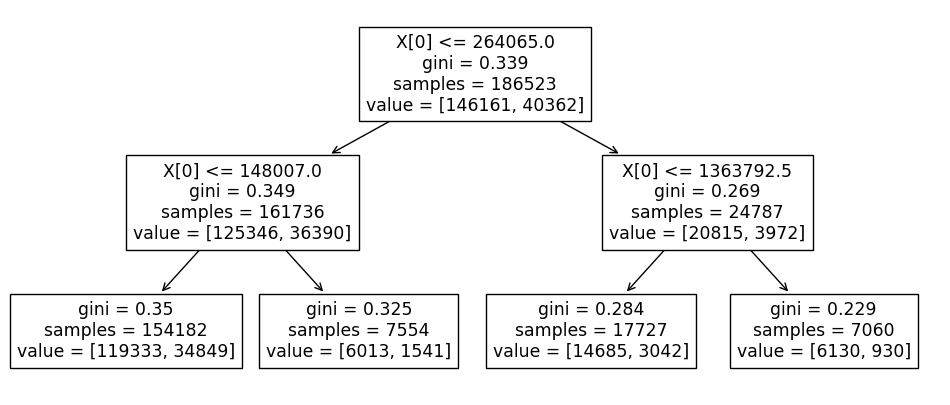

[0.13173, 0.1716, 0.204, 0.22603]


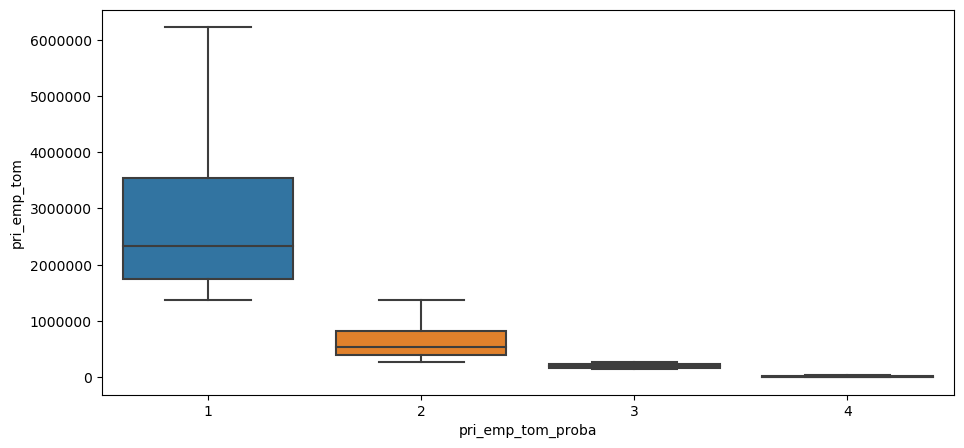

In [36]:
tree_box_plot(df, 'pri_emp_tom', 'default', [2], seed, True)

In [37]:
# combinando 'pri_qtd_tot_emp' e 'pri_qtd_tot_emp_atv'
# transformação 'intuitiva', dado que há correlação, como visto acima
# (a metadata sobre desta nova variável seria: 'empréstimos passados')
df['past_emp'] = df['pri_qtd_tot_emp'] - df['pri_qtd_tot_emp_atv']

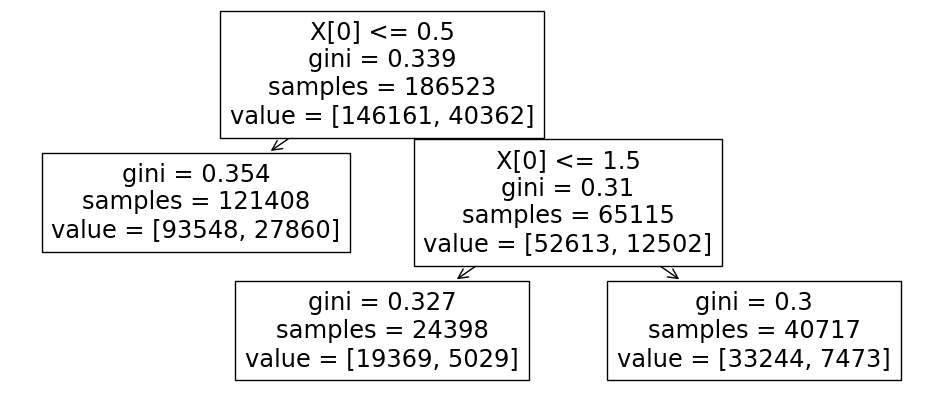

[0.18354, 0.20612, 0.22947]


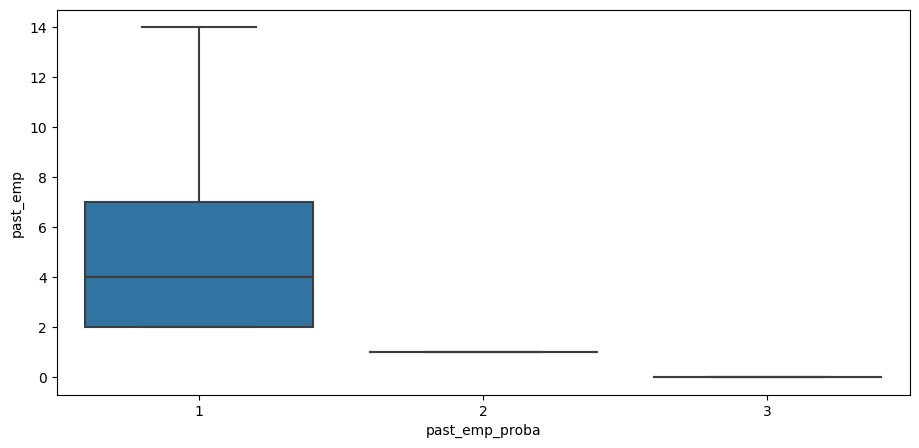

In [38]:
tree_box_plot(df, 'past_emp', 'default', [2], seed, True)

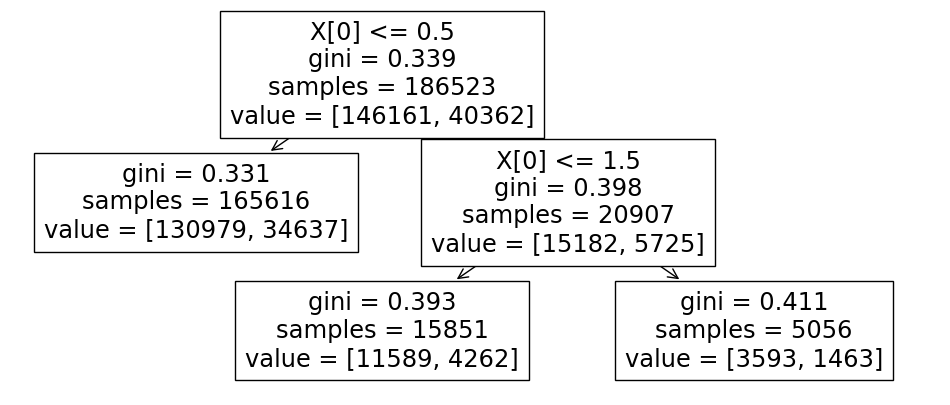

[0.20914, 0.26888, 0.28936]


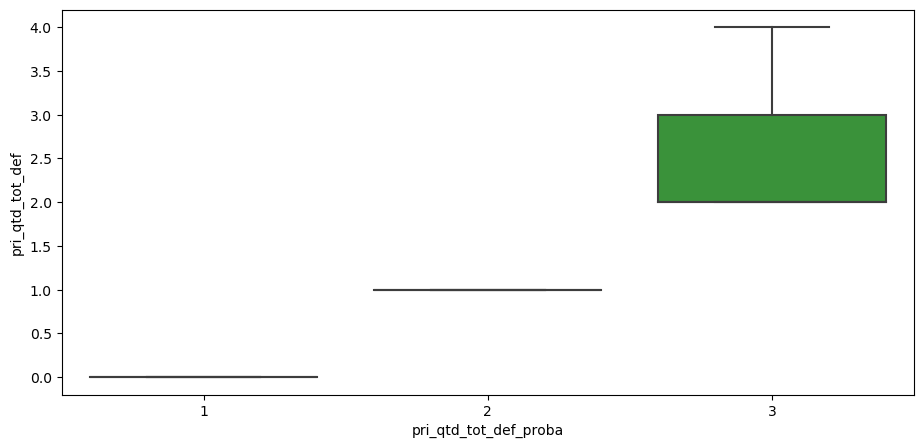

In [39]:
tree_box_plot(df, 'pri_qtd_tot_def', 'default', [2], seed, True)

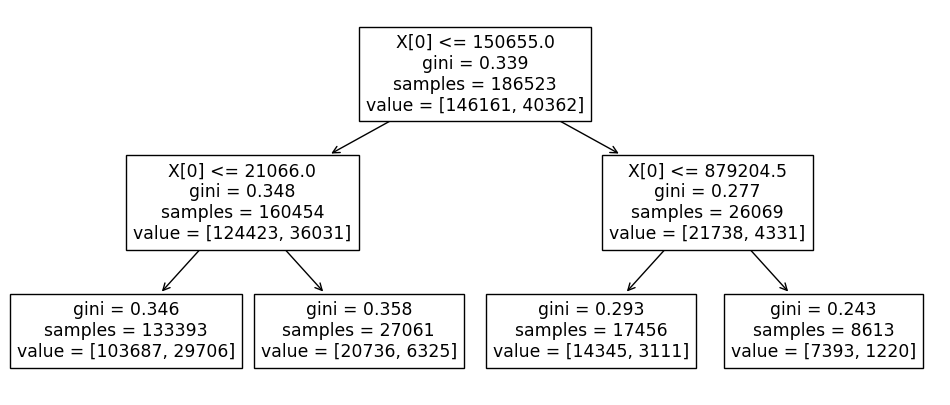

[0.14165, 0.17822, 0.2227, 0.23373]


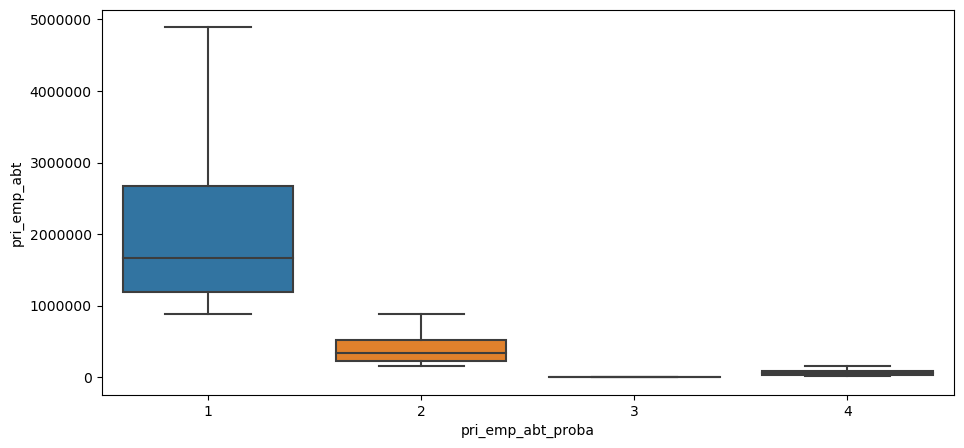

In [40]:
tree_box_plot(df, 'pri_emp_abt', 'default', [2], seed, True)

In [41]:
# conclusão de g.: eliminamos apenas 'pri_emp_abt', mantivemos a nova variável 'past_emp', além de
# 'pri_qtd_tot_def' e 'pri_emp_tom', posto que estas ordenam o 'default'

In [42]:
# neste ponto do notebook, nos restam apenas variáveis quantitativas, estas, que permanceram na análise, e 
# passarão para a próxima fase foram selecionadas por 'ordenarem o default', ou seja, a taxa de inadimplência
# sobe ou desce conforme o valor discretizado da variável

# a próxima fase consiste em passar as variáveis restantes em algo similar ao 'backwards stepwise regression',
# este processo se inicia ajustando uma regressão logística aos dados, primeiramente, incluindo todas as 
# variáveis explicativas disponíveis, e armazenando a métrica obtida com o uso das mesmas, em seguida, 
# é ajustado um novo modelo, mas desta vez, com uma variável a menos, a 'menos importante'(de acordo com seu
# coeficiente) é eliminada, então armazenamos a métrica deste novo conjunto, e repetimos o processo, até que 
# reste apenas uma variável; para finalizar o stepwise, plotamos os resultados obtidos com cada conjunto de 
# variáveis, com este plot, optamos pelo conjunto de features que preserve a métrica e ao mesmo tempo, reduza
# a dimensionalidade do dataframe

# variáveis restantes:

# dif_val_custo_proba (custo_ativo - valor_emprestimo)
# emprestimo_custo_proba
# idade_proba (transformação de 'nasimcento')
# score
# tem_med_emp_proba ('unidade' transformada)
# tem_pri_emp_proba ('unidade' transformada)
# qtd_sol_emp
# pri_emp_tom_proba
# past_emp_proba (pri_qtd_tot_emp - pri_qtd_tot_emp_atv)
# pri_qtd_tot_def_proba

# variáveis eliminadas na etapa anterior: 

# emprego (de acordo com testes estatísticos, não possui associação significante com o alvo)  
# score_desc (redundante 'score' pareceu já trazer as informações presentes nesta) 
# pri_emp_san (redundante 'pri_emp_tom' pareceu já trazer as informações presentes nesta)
# pri_emp_abt (não ordena o 'default')

# nota sobre o stepwise:
# antes é necessário tratar 'score', durante a análise de discretização, pudemos perceber que seria 
# necessário alocar valores de 0-18 sob a categoria '0' com antecedência, mas não tratamos os dados naquele
# momento

# random_state do stepwise foi setado para 42, tinha a intenção de usar 'seed'(123) no projeto inteiro, mas
# por distração, mantive 42 nos splits de treino e teste do stepwise, este comentário está sendo escrito
# no dia da entrega do projeto, não tennho tempo suficiente para muitos ajustes, esta inconsistência
# não será sanada

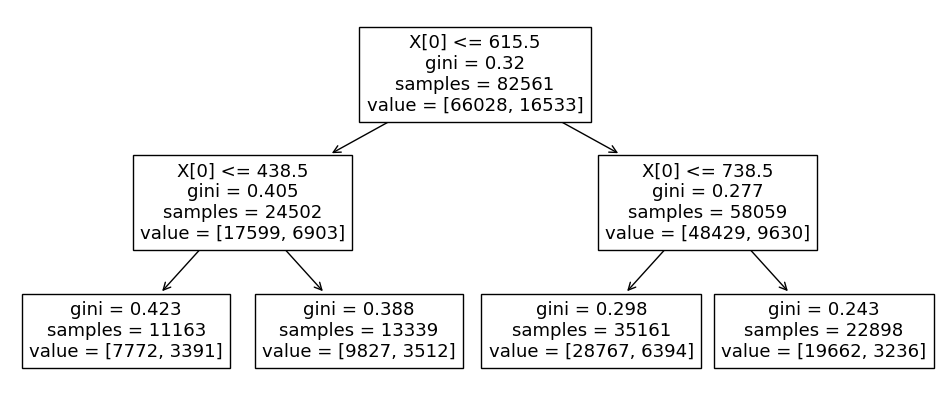

In [43]:
# obtendo limiares para tratamento do 'score' (preparativo para o stepwise)
# a função 'tratar_score1()' já leva em consideração o fato de que devemos alocar valores de 0-20 sob o inteiro
# '0', os limiares apresentados foram obtidos ao ajustarmos a árvore nos dados de valor superior a 20
tratar_score1(df, 'score', 'default', seed)

In [44]:
# tratando 'score' (discretização de acordo com limiares da árvore, este que são passados como parâmetros)
df = tratar_score2(df, 'score', 'default', 438.5, 615.5, 738.5)

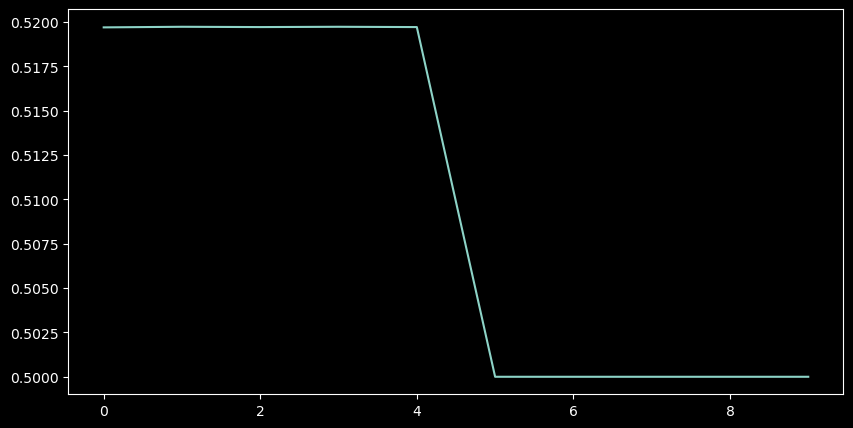

FEATURES INCLUÍDAS EM CADA STEP
0 : ['dif_val_custo_proba', 'emprestimo_custo_proba', 'idade_proba', 'tem_med_emp_proba', 'new_score', 'tem_pri_emp_proba', 'qtd_sol_emp_proba', 'pri_emp_tom_proba', 'past_emp_proba', 'pri_qtd_tot_def_proba']
1 : ['dif_val_custo_proba', 'emprestimo_custo_proba', 'idade_proba', 'tem_med_emp_proba', 'new_score', 'tem_pri_emp_proba', 'qtd_sol_emp_proba', 'pri_emp_tom_proba', 'pri_qtd_tot_def_proba']
2 : ['dif_val_custo_proba', 'emprestimo_custo_proba', 'idade_proba', 'tem_med_emp_proba', 'new_score', 'tem_pri_emp_proba', 'qtd_sol_emp_proba', 'pri_emp_tom_proba']
3 : ['emprestimo_custo_proba', 'idade_proba', 'tem_med_emp_proba', 'new_score', 'tem_pri_emp_proba', 'qtd_sol_emp_proba', 'pri_emp_tom_proba']
4 : ['idade_proba', 'tem_med_emp_proba', 'new_score', 'tem_pri_emp_proba', 'qtd_sol_emp_proba', 'pri_emp_tom_proba']
5 : ['idade_proba', 'tem_med_emp_proba', 'tem_pri_emp_proba', 'qtd_sol_emp_proba', 'pri_emp_tom_proba']
6 : ['tem_med_emp_proba', 'tem_pri_emp

In [45]:
df = df.copy()[['dif_val_custo_proba' ,'emprestimo_custo_proba','idade_proba','tem_med_emp_proba','new_score',
'tem_pri_emp_proba','qtd_sol_emp_proba','pri_emp_tom_proba','past_emp_proba' ,'pri_qtd_tot_def_proba',
                'default']]
plot_stepwise(df, 'default')

In [46]:
# no step 3, obtivemos a métrica mais alta, com o menor número de features possível, para tal
# assim, trabalharemos com:

# 3 : ['emprestimo_custo_proba', 'idade_proba', 'tem_med_emp_proba', 'new_score', 'tem_pri_emp_proba', 
# 'qtd_sol_emp_proba', 'pri_emp_tom_proba']

# AQUI SE ENCERRA A ANÁLISE DA BASE

In [47]:
# AQUI SE INICIAM OS TESTES DE MODELOS

# definido o conjunto de variáveis com as quais trabalharemos, prosseguimos para a divisão de treino e teste
# da base, para tanto, utilizaremos um KFold Cross Validation(3 folds); é importante perceber que cada conjunto
# de splits treino e teste deve ser tratado separadamente no momento da discretização, para que não haja 
# data leak pela árvore, por exemplo, se tomarmos o primeiro split de treino e teste (treino_0 e teste_0); 
# após eliminarmos as variáveis que, anteriormente na análise, julgamos como menos interessantes, e 
# transformarmos as feautres, neste caso, 'nascimento', 'tem_med_emp' e 'tem_pri_emp'(as demais variáveis
# que transformamos com subtrações foram eliminadas no stepwise), quando formos discretizar os dados, devemos
# treinar a árvore no split de treino(treino_0), esta árvore 'transformará' o treino_0 e também teste_0; isso
# se repete nos demais conjuntos, por exmeplo, para treino_1 e teste_1, ajustaremos uma árvore aos dados 
# de treino_1, esta transformará tanto treino_1, como teste_1

# variáveis com as quais criamos as features selecionadas pelo stepwise (as variáveis passadas no stepiwse
# já tinham sido transformadas, como trabalharemos com validação cruzada, e cada conjunto deve ser 
# tranformado sob certas condições, carregamos os dados novamente, fazemos os splits e tratamos cada um
# desde o início)

# obtendo splits de treino e teste com as variáveis selecionadas no stepwise(splits tirados do dataframe
# original), também transforma feature 'nascimento' em 'idade' e trata 'tem_pri_emp' e 'pri_emp_tom' 

data = ['emprestimo_custo', 'nascimento', 'tem_med_emp', 'score', 'tem_pri_emp', 'qtd_sol_emp', 'pri_emp_tom',
 'default']
treino_0, teste_0, treino_1, teste_1, treino_2, teste_2 = post_stepwise_split(data)

# parâmetro 'data': define quais series farão parte de cada split retornado pela função
# o retorno da função consiste em splits de treino e teste, com apenas as features selecionadas anteriormente, 
# durante a análise

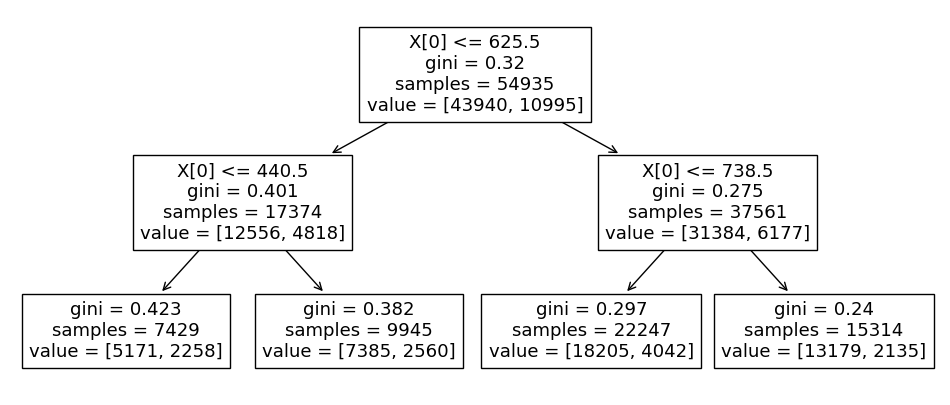

In [48]:
# obtendo limiares para tratamento de 'score' em cada split (usando split de teste para treinar árvores)

tratar_score1(treino_0, 'score', 'default', seed)

In [49]:
limiares0 = [440.5, 625.5, 738.5]

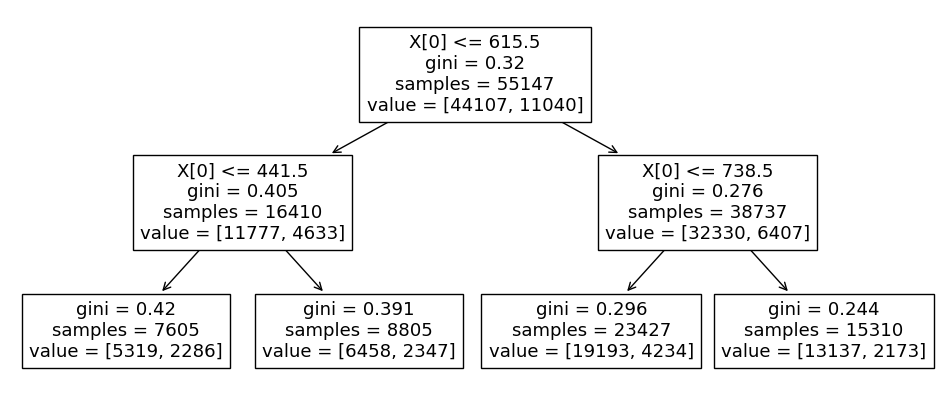

In [50]:
tratar_score1(treino_1, 'score', 'default', seed)

In [51]:
limiares1 = [441.5, 615.5, 738.5]

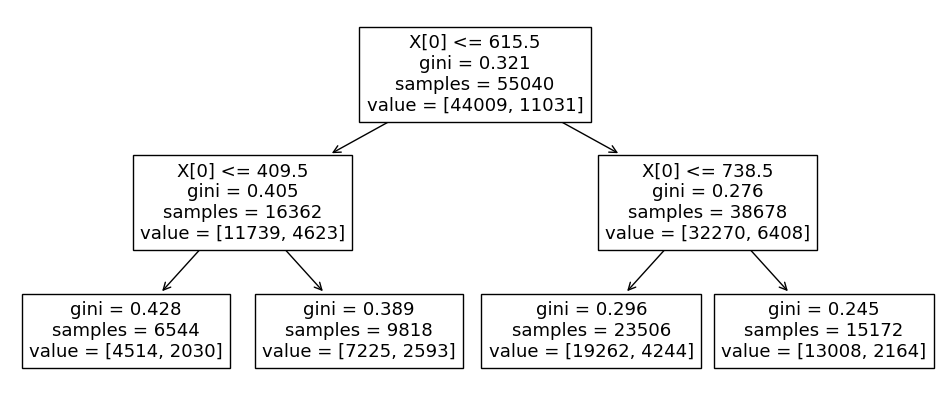

In [52]:
tratar_score1(treino_2, 'score', 'default', seed)

In [53]:
limiares2 = [409.5, 615.5, 738.5]

In [54]:
# aqui não passar 'score' como parâmetro, nem default, 'nascimento' como idade
data = ['emprestimo_custo', 'idade', 'tem_med_emp', 'tem_pri_emp', 'qtd_sol_emp', 'pri_emp_tom']


# aqui é feita a discretização de todas as features (através de árvores, com atenção ao data leak; cada split
# é discretizado separadamente, em cada conjunto treino e teste, a árvore que transforma o teste foi ajustada
# com o split de treino)
# para 'score', passamos como parâmetro, os limiares obtidos nas árovres treinadas nos dados de teste de cada 
# split (o tratamento da variável 'score' está 'embutido' na função)
teste_0, teste_1, teste_2, treino_0, treino_1, treino_2 = post_stepwise_split_discretization(teste_0,teste_1,
                                                                                             teste_2,treino_0,
                                                                                             treino_1,treino_2,
                                                                                             data,
                                                                                             limiares0, 
                                                                                             limiares1,
                                                                                             limiares2)

In [55]:
# aqui, obtemos as métricas para os algoritmos LogisticRegression e LGBMClassifier,
# tiramos o gini, posto que é a métrica sob a qual o modelo será avaliado, de acordo com a proposta
# do projeto

# lista com as variáveis explicativas dos splits (será passada como parâmetro na função que obtém métricas)
data = treino_0.columns.tolist()
data.remove('default') 

# testando modelos com diferentes splits (como foi explicado anteriormente, utilizamos três folds na validação
# cruzada, logo, obteremos três métricas para cada modelo)

lgbm_scores, lr_scores = lr_lgbm_score(treino_0, teste_0 ,treino_1, teste_1 ,treino_2, teste_2, data)
lr_performance = score_data(lr_scores)
lgbm_performance = score_data(lgbm_scores)
lr_score_std = np.std([i[0] for i in lr_scores])
lgbm_score_std = np.std([i[0] for i in lgbm_scores])

In [56]:
# criando a tabela resumo contendo as métricas dos modelos

df_var_data = ['emprestimo_custo_proba', 'idade_proba', 'tem_med_emp_proba', 'new_score', 'tem_pri_emp_proba', 
 'qtd_sol_emp_proba', 'pri_emp_tom_proba']
r1 = ['LR', df_var_data, lr_performance['test_avg'], lr_performance['train_avg'],
      lr_performance['overfit_avg'], lr_score_std]
r2 = ['LGBM', df_var_data, lgbm_performance['test_avg'], lgbm_performance['train_avg'], 
      lgbm_performance['overfit_avg'], lgbm_score_std]
df_report = pd.DataFrame([r1, r2], columns = ['model', 'vars', 'test_avg', 'train_avg', 'overfit_avg', 
                                              'test_score_std'])
# salvando a tabela resumo
# df_report.to_pickle('373_amarelo_tabela_resumo.pkl')

In [57]:
df_report

,model,vars,test_avg,train_avg,overfit_avg,test_score_std
0,LR,"[emprestimo_custo_proba, idade_proba, tem_med_...",0.204769,0.205105,0.000336,0.008656
1,LGBM,"[emprestimo_custo_proba, idade_proba, tem_med_...",0.204161,0.262043,0.057882,0.004950


In [58]:
# sobre os resultados das validações e seleção de um modelo para predição da base que deve ser entregue: 
# ao comparar os dois modelos, podemos notar que ambos trazem métricas semelhantes, mas lgbm overfitou mais,
# além disso, no contexto do projeto, acreditamos que a explicabilidade seja importante, 
# optamos pela regressão logística

# AQUI SE ENCERRAM OS TESTES DE MODELOS

In [59]:
# AQUI SE INICIA A PREDIÇÃO DA BASE DE TESTE (A SER ENTREGUE)

# foi estabelecido que utilizaremos a regressão logística, portanto, daremos início aos preparativos dos dados
# para treinamento de um modelo destinado à predição da base de teste

# treinando modelo (Regressão Logística) com a base inteira (base contendo infromação sobre o 'default')
# também realizo o pré processamento das bases de treino ('base inteira') e teste

df = pd.read_pickle('treino.pkl.gz')
df['nascimento'] = df['nascimento'].str[6:].apply(lambda x: year_to_age(x))
df = df.rename(columns = {'nascimento': 'idade'})
df['tem_med_emp'] = df['tem_med_emp'].apply(lambda x: time_unit_unification(x))
df['tem_pri_emp'] = df['tem_pri_emp'].apply(lambda x: time_unit_unification(x))

expl = ['score', 'nascimento', 'tem_med_emp', 'tem_pri_emp', 'qtd_sol_emp', 'emprestimo_custo', 'pri_emp_tom']
trgt = ['default']

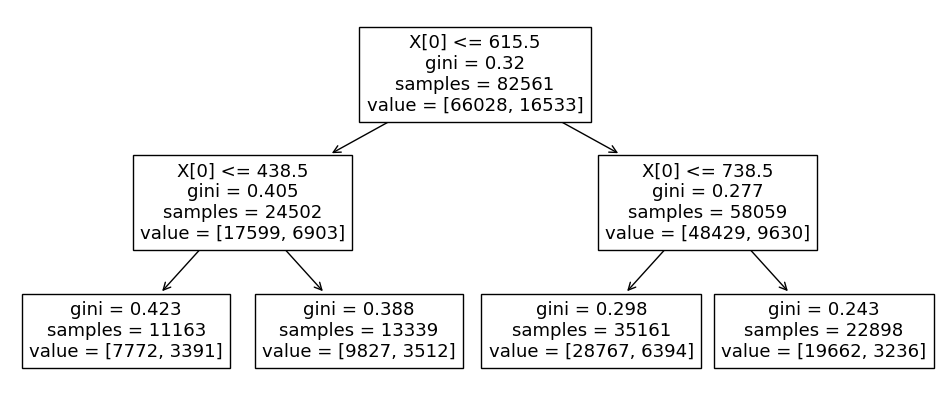

In [60]:
# buscando limiares com os quais será discretizada a feature 'score' nas bases de treino e teste
tratar_score1(df, 'score', 'default', seed)

In [61]:
# discretizando score na base de treino
df = tratar_score2(df, 'score', 'default', 438.5, 615.5, 738.5)
# discretizando outras features da base de treino
for col in ['emprestimo_custo', 'idade', 'tem_med_emp', 'tem_pri_emp', 'qtd_sol_emp', 'pri_emp_tom']:
    tree_box_plot(df, col, 'default', [2], seed, False)
    clear_output()
    
x = df[['emprestimo_custo_proba', 'idade_proba', 'tem_med_emp_proba', 'tem_pri_emp_proba',
    'qtd_sol_emp_proba', 'new_score', 'pri_emp_tom_proba']]
y = df[['default']]
y = y.values.ravel()

lr = LogisticRegression()
lr.fit(x, y)
# salvando modelo
# pickle.dump(lr, open('373_amarelo_modelo_lr.pkl', 'wb'))

In [62]:
# processo não muito prático, aqui realizo o pré processamento da base de teste (já temos os limiares para
# discretização do 'score', de acordo com a árvore treinada na base de treino)

df = pd.read_pickle('treino.pkl.gz')
teste_base = pd.read_pickle('teste_sem_alvo.pkl.gz')

df = df.copy()[['score', 'emprestimo_custo', 'nascimento', 'tem_med_emp', 
                                'tem_pri_emp', 'qtd_sol_emp', 'pri_emp_tom', 'default']]

teste_base = teste_base.copy()[['id_pessoa', 'score', 'emprestimo_custo', 'nascimento', 'tem_med_emp', 
                                'tem_pri_emp', 'qtd_sol_emp', 'pri_emp_tom']]

df['nascimento'] = df['nascimento'].str[6:].apply(lambda x: year_to_age(x))
df = df.rename(columns = {'nascimento': 'idade'})
df['tem_med_emp'] = df['tem_med_emp'].apply(lambda x: time_unit_unification(x))
df['tem_pri_emp'] = df['tem_pri_emp'].apply(lambda x: time_unit_unification(x))

teste_base['nascimento'] = teste_base['nascimento'].str[6:].apply(lambda x: year_to_age(x))
teste_base = teste_base.rename(columns = {'nascimento': 'idade'})
teste_base['tem_med_emp'] = teste_base['tem_med_emp'].apply(lambda x: time_unit_unification(x))
teste_base['tem_pri_emp'] = teste_base['tem_pri_emp'].apply(lambda x: time_unit_unification(x))

# *** este bloco treina árvores nas series de treino e aplica as transformações aos dados de teste ***
for col in ['emprestimo_custo', 'idade', 'tem_med_emp', 'tem_pri_emp', 'qtd_sol_emp', 'pri_emp_tom']:
    discretize(df, teste_base, col, 'default', seed)
    
# tratando 'score' da base de teste com limiares obtidos no modelo treinado na base de treino
teste_base = tratar_score2(teste_base, 'score', 'default', 438.5, 615.5, 738.5)

In [63]:
# com os preparativos todos finalizados, realizo as predições da base que deve ser entregue e armazeno-as 
# em um dataframe, contendo também, a series 'id_pessoa'

preds = [i[1] for i in lr.predict_proba(teste_base[['emprestimo_custo_proba', 'idade_proba', 
                                                   'tem_med_emp_proba', 'tem_pri_emp_proba',
                                                   'qtd_sol_emp_proba', 'pri_emp_tom_proba',
                                                   'new_score']])]

ids = teste_base['id_pessoa']
data = []
for i in zip(preds, ids):
    data.append([i[1], i[0]])
df_pred = pd.DataFrame(data)
df_pred = df_pred.rename(columns = {0: 'id_pessoa', 1: 'proba'})

# salvando a base com as predições
# df_pred.to_pickle('373_amarelo_preds.pkl')

# considerações finais:
# por falta de organização minha (Fernando), o pré processamento ficou confuso e mais trabalhoso do que deveria,
# além disso, me investi completamente em trazer um modelo explicável, assim, não tive tempo suificente
# para trabalhar em uma alternativa menos explicável, que trouxesse uma métrica mais alta

# FIM